In [145]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

plt.style.use("dark_background")
np.random.seed(21)
eps = 1.0e-10

# Problem definition
x_min = 0.0
x_max = 1.0
n_cells = 30
# n_iters = 300
# n_iters = 500
n_iters = 1000
analytical = np.linspace(x_min, x_max, n_cells + 1)

# Space-Iter mesh definition
class SpaceIterMesh:
   def __init__(self, n_cells: int, n_iter: int):
      self.seed_matrix = np.zeros((n_cells, n_iter))
      self.bound_matrix = np.zeros((n_cells + 1, n_iter))

mesh = SpaceIterMesh(n_cells, n_iters)

In [146]:
def plot_cells(mesh: SpaceIterMesh, iteration: int):
   """Plot cells for a single iteration (static plot)."""
   seeds = mesh.seed_matrix[:, iteration]
   bounds = mesh.bound_matrix[:, iteration]
   
   assert len(bounds) == len(seeds) + 1, "cell_bounds must have one more entry than cell_seeds"
   assert np.all(seeds[:-1] <= seeds[1:]), "Ensure that cell_seeds is sorted"
   assert np.all(bounds[:-1] <= bounds[1:]), "Ensure that cell_bounds is sorted"

   x_min = bounds[0]
   x_max = bounds[-1]

   plt.figure(figsize=(10, 0.5))
   
   # Plot cell seeds
   plt.plot(seeds, np.zeros_like(seeds), 'o', markersize=4, markerfacecolor='white', 
            markeredgecolor='white', markeredgewidth=0, alpha=0.8)
   plt.title(f'1D Cells Plot - Iteration {iteration}')
   plt.xlim(x_min, x_max)
   plt.ylim(-1, 1)
   plt.xlabel('X')
   plt.ylabel('Y')

   # Plot interior cell boundaries
   for bound in bounds[1:-1]:
       plt.axvline(x=bound, color='red', linestyle='-', linewidth=1, alpha=0.5)

   plt.show()

In [147]:
def plot_bound_paths(mesh: SpaceIterMesh, start_iter: int = 0, end_iter: int = n_iters-1):
   """Plot cell boundary paths over iterations (static plot)."""
   # Get the iteration range
   iterations = np.arange(start_iter, end_iter + 1)
   n_bounds = n_cells + 1
   
   # Create figure with same width as static plot
   plt.figure(figsize=(10, 8))
   
   # Plot each seed path as a separate line
   for bound_idx in range(n_bounds):
       # Extract seed positions for this seed across all iterations
       bound_positions = mesh.bound_matrix[bound_idx, start_iter:end_iter+1]
       
       # Plot with negative iterations (so iteration 0 is at top) but use white color
       plt.plot(bound_positions, -iterations, '-', color='red', linewidth=1, alpha=0.8)
   
   # Set labels and title
   plt.xlabel('Cell Boundary Positions')
   plt.ylabel('Iteration')
   plt.title(f'Cell Boundary Paths Over Iterations {start_iter} to {end_iter}')
   
   # Set axis limits
   plt.xlim(x_min, x_max)
   plt.ylim(-end_iter, -start_iter + 1)
   
   # Customize y-axis to show positive iteration numbers
   y_ticks = np.arange(-end_iter, -start_iter + 1, max(1, (end_iter - start_iter) // 10))
   y_labels = [-tick for tick in y_ticks]  # Convert back to positive for display
   plt.yticks(y_ticks, y_labels)
   
   # Show the plot
   plt.show()

In [148]:
def animate_cells(mesh: SpaceIterMesh, start_iter: int = 0, end_iter: int = n_iters-1, interval: int = 50):
   """Create an animated plot showing cell evolution over iterations."""
   # Set up the figure and axis
   fig, ax = plt.subplots(figsize=(10, 0.5))
   
   # Get global bounds for consistent axis limits
   x_min = mesh.bound_matrix[0, :].min()
   x_max = mesh.bound_matrix[-1, :].max()
   
   ax.set_xlim(x_min, x_max)
   ax.set_ylim(-1, 1)
   ax.set_xlabel('X')
   ax.set_ylabel('Y')
   
   # Initialize empty plot elements
   seeds_plot, = ax.plot([], [], 'o', markersize=4,
                        markerfacecolor='white', markeredgecolor='white', markeredgewidth=0, alpha=0.8)
   boundary_lines = []
   
   def animate(frame):
       iteration = start_iter + frame
       seeds = mesh.seed_matrix[:, iteration]
       bounds = mesh.bound_matrix[:, iteration]
       
       # Clear previous boundary lines
       for line in boundary_lines:
           line.remove()
       boundary_lines.clear()
       
       # Update seeds
       seeds_plot.set_data(seeds, np.zeros_like(seeds))
       
       # Add boundary lines
       for bound in bounds[1:-1]:
           line = ax.axvline(x=bound, color='red', linestyle='-', linewidth=1, alpha=0.5)
           boundary_lines.append(line)
       
       # Update title
       ax.set_title(f'1D Cells Plot - Iteration {iteration}')
       
       return [seeds_plot] + boundary_lines
   
   # Create animation
   num_frames = end_iter - start_iter + 1
   anim = FuncAnimation(fig, animate, frames=num_frames, interval=interval, blit=False, repeat=True)
   
   # Close the figure to prevent it from being displayed as a static plot
   plt.close(fig)
   
   return anim

In [149]:
def cell_size(x: float) -> float:
   c0 = 0.01
   c1 = 0.0
   return c1 * x + c0

def cell_density(x: float) -> float:
   sz = cell_size(x)
   assert sz > eps, "Cell size must be positive"
   return 1.0 / sz

def update_cell_bounds(mesh: SpaceIterMesh, iter: int):
   seeds = mesh.seed_matrix[:, iter]
   bounds = mesh.bound_matrix[:, iter]

   assert len(bounds) == len(seeds) + 1, "cell_bounds must have one more entry than cell_seeds"
   assert np.all(seeds[:-1] <= seeds[1:]), "Ensure that cell_seeds is sorted"
   assert x_min <= seeds[0] <= x_max, "Ensure that cell_seeds is within [x_min, x_max]"
   assert x_min <= seeds[-1] <= x_max, "Ensure that cell_seeds is within [x_min, x_max]"
   
   bounds[0] = x_min
   bounds[-1] = x_max
   
   for i in range(1, len(seeds)):
       bounds[i] = 0.5 * (seeds[i - 1] + seeds[i])

def update_cell_seeds(mesh: SpaceIterMesh, iter: int):
   assert iter < n_iters - 1, "Cannot update beyond the last iteration"
   cell_bounds = mesh.bound_matrix[:, iter]
   cell_seeds_new = mesh.seed_matrix[:, iter + 1]

   for ic in range(n_cells):
       cell_min = cell_bounds[ic]
       cell_max = cell_bounds[ic + 1]
       cell_mid = 0.5 * (cell_min + cell_max)
       cell_seeds_new[ic] = cell_mid

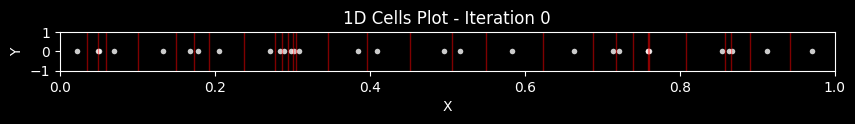

In [150]:
# Generate random x values for the first iteration, sort them, and compute cell boundaries
mesh.seed_matrix[:, 0] = np.sort(np.random.uniform(x_min, x_max, n_cells))
update_cell_bounds(mesh, 0)

plot_cells(mesh, 0)

### Iterations

In [151]:
for iter in range(n_iters - 1):
    update_cell_bounds(mesh, iter)
    update_cell_seeds(mesh, iter)

In [152]:
anim = animate_cells(mesh, interval=100)
HTML(anim.to_jshtml())

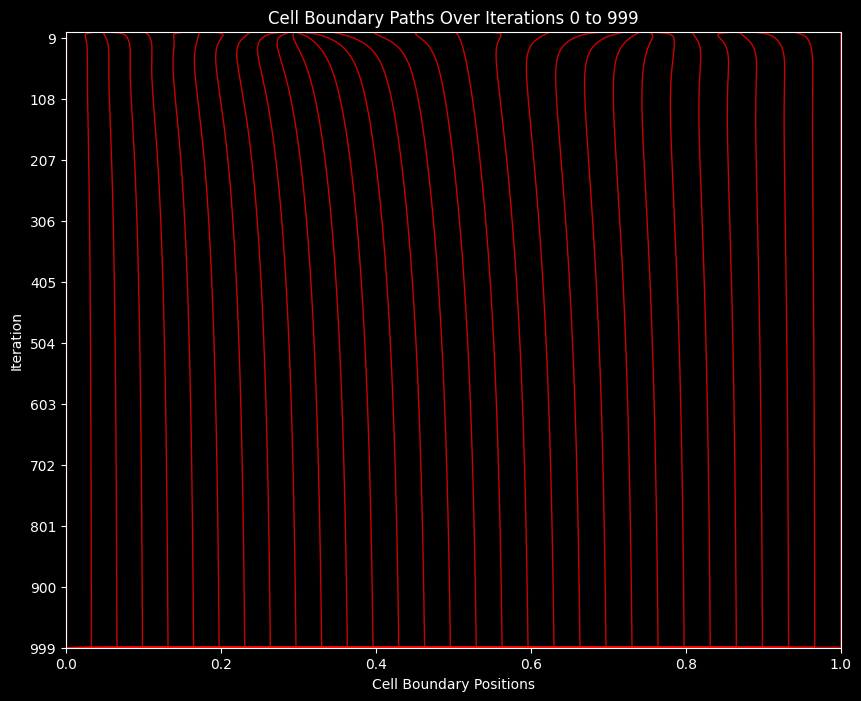

In [153]:
plot_bound_paths(mesh, 0, n_iters-1)